In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import os
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image
import os
import zipfile
from tqdm.notebook import tqdm

In [ ]:
#https://www.kaggle.com/mahmoudima/mma-facial-expression
! ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle
! kaggle datasets download mahmoudima/mma-facial-expression

 94% 156M/166M [00:02<00:00, 73.7MB/s]
100% 166M/166M [00:02<00:00, 69.9MB/s]


In [2]:
datasetPath = "./drive/MyDrive/Colab Notebooks/Capstone Project/Facial Expression Dataset Filtered.zip"
#datasetPath = "./mma-facial-expression.zip"
with zipfile.ZipFile(datasetPath) as file :
    file.extractall()

In [ ]:
"""
disgust : 3231
happy : 28592
surprise : 8113
neutral : 29384
sad : 12223
angry : 6566
fear : 4859
"""

for i in os.listdir("./Facial Expression Dataset/train") :
    print(i, ":", len(os.listdir("./Facial Expression Dataset/train/" + i)))

fear : 4859
happy : 28210
angry : 5751
neutral : 28409
surprise : 8113
disgust : 3231
sad : 10820


In [4]:
def prepareImage(path):
    #img = tf.keras.preprocessing.image.load_img(file, target_size=(224, 224))
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (48, 48))
    #img = tf.keras.preprocessing.image.img_to_array(img)
    return img
    #img = np.expand_dims(img, axis=0)
    #return tf.keras.applications.mobilenet.preprocess_input(img)

In [7]:
trainDir = "./Facial Expression Dataset Filtered/train/"
#trainDir = "./MMAFEDB/train/"
expression = ["angry", "happy", "neutral", "sad"]

imgTrain = []
labelTrain = []

numOfData = 5000
for label, labelName in enumerate(expression) :
    for i in tqdm(os.listdir(trainDir + labelName)[:numOfData]) :
        imgTrain.append(prepareImage(os.path.join(trainDir, labelName, i)))
        tempLabel = np.zeros(len(expression))
        tempLabel[label] = 1
        labelTrain.append(tempLabel)
        #labelTrain.append(label)
        #imgTrain = np.concatenate((imgTrain, prepareImage(trainDir + i + "/" + j)))

imgTrain = np.array(imgTrain)
labelTrain = np.array(labelTrain)

index = np.arange(len(expression) * numOfData)
np.random.seed(1)
np.random.shuffle(index)

imgTrain = imgTrain[index]
labelTrain = labelTrain[index]

In [ ]:
for i in labelTrain[:100] :
    print(i)

In [4]:
baseModel = tf.keras.applications.MobileNetV2(include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(baseModel.output)
dense1 = tf.keras.layers.Dense(100, activation="relu")(avg)
dense2 = tf.keras.layers.Dense(100, activation="relu")(dense1)
output = tf.keras.layers.Dense(len(expression), activation="softmax")(dense2)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=output)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

for i in baseModel.layers :
    i.trainable = True

#model.summary()

In [17]:
history = model.fit(imgTrain, labelTrain, epochs=30, validation_split=0.1)

Epoch 1/30
338/338 [==============================] - 8s 24ms/step - loss: 0.4461 - accuracy: 0.8329 - val_loss: 1.6384 - val_accuracy: 0.5908
Epoch 2/30
338/338 [==============================] - 8s 24ms/step - loss: 0.3952 - accuracy: 0.8509 - val_loss: 1.5995 - val_accuracy: 0.5750
Epoch 3/30
338/338 [==============================] - 8s 23ms/step - loss: 0.3687 - accuracy: 0.8659 - val_loss: 1.8162 - val_accuracy: 0.5625
Epoch 4/30
338/338 [==============================] - 8s 23ms/step - loss: 0.3520 - accuracy: 0.8726 - val_loss: 2.2766 - val_accuracy: 0.5367
Epoch 5/30
338/338 [==============================] - 8s 23ms/step - loss: 0.3527 - accuracy: 0.8733 - val_loss: 1.6833 - val_accuracy: 0.5725
Epoch 6/30
338/338 [==============================] - 8s 23ms/step - loss: 0.3042 - accuracy: 0.8903 - val_loss: 1.8709 - val_accuracy: 0.5592
Epoch 7/30
338/338 [==============================] - 8s 22ms/step - loss: 0.3015 - accuracy: 0.8927 - val_loss: 1.6112 - val_accuracy: 0.6083

(1, 48, 48, 3)


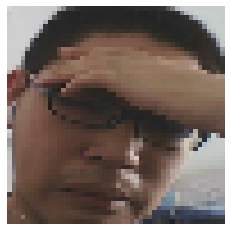

[[0.1020152  0.00127829 0.03305477 0.86365175]] 
 sad


In [39]:
#img = cv2.imread("./angry999.png")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img, (48, 48))
img = prepareImage("./sad9001.png")
img = np.expand_dims(img, axis=0)
img = img
print(img.shape)

plt.imshow(img[0])
plt.axis("off")
plt.show()

prediction = model.predict(img)
print(prediction, "\n", expression[np.argmax(prediction)])

In [18]:
#testDir = "./Facial Expression Dataset/test/"
testDir = "./Facial Expression Dataset/test/"
#expression = ["angry", "happy", "neutral", "sad"]
#expression = ["angry", "happy"]

imgTest = []
labelTest = []

numOfData = 500
for label, labelName in enumerate(expression) :
    for i in tqdm(os.listdir(testDir + labelName)[:numOfData]) :
        imgTest.append(prepareImage(os.path.join(testDir, labelName, i)))
        tempLabel = np.zeros(len(expression))
        tempLabel[label] = 1
        labelTest.append(tempLabel)
        #labelTrain.append(label)
        #imgTrain = np.concatenate((imgTrain, prepareImage(trainDir + i + "/" + j)))

imgTest = np.array(imgTest)
labelTest = np.array(labelTest)

prediction = model.predict(imgTest)
cm = confusion_matrix(np.argmax(labelTest, axis=1), np.argmax(prediction, axis=1))
#for i in prediction :
#    print(np.argmax(i))

[[357  22  34  87]
 [ 61 217 106 116]
 [ 88  58 233 121]
 [107  53 117 223]]
Label : angry    Prediction : sad


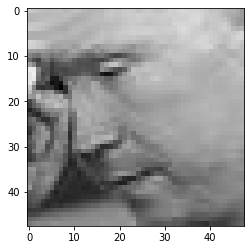

In [19]:
print(cm)
index = 0
print("Label :", expression[np.argmax(labelTest[index])], "   Prediction :", expression[np.argmax(prediction[index])])
plt.imshow(imgTest[index])
plt.show()

In [ ]:
import os

baseDir = "./MMAFEDB"
trainDir = os.path.join(baseDir, "train")
valDir = os.path.join(baseDir, "valid")
testDir = os.path.join(baseDir, "test")

trainDatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0,
                                                               rotation_range = 40,
                                                               width_shift_range = 0.2,
                                                               height_shift_range = 0.2,
                                                               shear_range = 0.2,
                                                               zoom_range = 0.2,
                                                               horizontal_flip = True)

testDatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

trainGenerator = trainDatagen.flow_from_directory(trainDir,
                                                   batch_size = 20,
                                                   class_mode = 'categorical', 
                                                   target_size = (224, 224))     

validationGenerator = testDatagen.flow_from_directory(valDir,
                                                       batch_size  = 20,
                                                       class_mode  = 'categorical', 
                                                       target_size = (224, 224))

Found 92968 images belonging to 7 classes.
Found 17356 images belonging to 7 classes.


In [ ]:
history = model.fit(
            trainGenerator,
            validation_data = validationGenerator,
            steps_per_epoch = 100,
            epochs = 5,
            validation_steps = 50)

In [40]:
model.save("./model happy angry neutral sad good")

INFO:tensorflow:Assets written to: ./model happy angry neutral sad good/assets


In [41]:
! zip -rq "model happy angry neutral sad good.zip" "model happy angry neutral sad good"